In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
import sys
import seaborn as sns

from sklearn.metrics import pairwise, auc
from tqdm import tqdm, trange
from torch.nn.utils.rnn import pad_sequence
from TTS.tts.configs.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from scipy.io import wavfile

from metrics import sMMD, kernel_noise, dist_var, dist_corr, kernel_error

output_path = 'tts_train_dir/'

In [2]:
def force_seq_len(seqs, length):
    seqs = [torch.from_numpy(seq) for seq in seqs]
    dummy_seq = [torch.zeros((length,))]
    all_seqs = pad_sequence(dummy_seq + seqs)
    # rm dummy seq and cut to desired length
    seqs = all_seqs[:,1:][:length]
    return seqs

def eval_metrics(audio_id, epoch, wavs_tensor, embs_tensor, target_wav):
    result = {'audio_unique_name': audio_id}
    result['epoch'] = epoch
    result['k_err_rbf'] = np.mean([
        kernel_error(wav, [target_wav]) for wav in wavs_tensor
    ])
    result['k_err_lap'] = np.mean([
        kernel_error(wav, [target_wav], kernel=pairwise.laplacian_kernel)
        for wav in wavs_tensor
    ])
    result['var_rbf'] = dist_var(wavs_tensor)
    result['var_lap'] = dist_var(wavs_tensor, kernel=pairwise.laplacian_kernel)
    result['k_ent_rbf'] = kernel_noise(wavs_tensor[0])
    result['k_ent_lap'] = kernel_noise(wavs_tensor[0], kernel=pairwise.laplacian_kernel)
    result['var_rbf_emb'] = dist_var(embs_tensor)
    result['var_lap_emb'] = dist_var(embs_tensor, kernel=pairwise.laplacian_kernel)
    result['k_ent_rbf_emb'] = kernel_noise(embs_tensor[0])
    result['k_ent_lap_emb'] = kernel_noise(
        embs_tensor[0], kernel=pairwise.laplacian_kernel
    )
    result['avg_wav_len'] = (wavs_tensor!=0).sum()/(
        wavs_tensor.shape[0]*wavs_tensor.shape[1]
    )
    result['avg_wav_sum'] = wavs_tensor.sum()/(
        wavs_tensor.shape[0]*wavs_tensor.shape[1]
    )
    return result

In [3]:
dataset_config = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path=os.path.join(output_path, "LJSpeech-1.1/")
)

train_samples, eval_samples = load_tts_samples(
    dataset_config,
    eval_split=True,
    eval_split_max_size=None,
    eval_split_size=0.1,
    #eval_split_size=0.01,
)
eval_samples = pd.DataFrame(eval_samples)

 | > Found 13100 files in /home/sgruber/Repositories/uncertainty_prompt_models/tts_train_dir/LJSpeech-1.1


In [35]:
id_to_target_wav = {}
# load the target wavs from audio files
for _, row in tqdm(eval_samples.iterrows(), total=eval_samples.shape[0]):
    audio_file = row['audio_file']
    audio_id = row['audio_unique_name']
    samplerate, target_wav = wavfile.read(audio_file)
    id_to_target_wav[audio_id] = target_wav

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1310/1310 [00:00<00:00, 3297.49it/s]


In [ ]:
n_eval = 100 #130
n_seed = 12
results_df = []
for epoch in trange(36000, 0, -2000):
    gen_df = []
    for seed in range(n_seed):
        with open(output_path + 'wav_generations_seed{}_epoch{}.pkl'.format(seed, epoch), 'rb') as infile:
            generations = pickle.load(infile)
            generations = pd.DataFrame(generations)
            # only pick first ten for less memory consumption
            generations = generations[generations['gen_id']<=9]
            gen_df.append(generations)
    gen_df = pd.concat(gen_df)
    gen_df = gen_df.reset_index(drop=True)

    for audio_id in gen_df['audio_unique_name'].unique()[0:n_eval]:
        sub_df = gen_df[gen_df['audio_unique_name']==audio_id]
        n_gens = sub_df['gen_id'].max() + 1
        max_seq_len = sub_df['gen_wav'].apply(lambda x: len(x)).max()
        wavs_tensor = np.zeros((n_seed, n_gens, max_seq_len))
        embs_tensor = np.zeros((n_seed, n_gens, 512))
        for index, row in sub_df.iterrows():
            wav_len = len(row['gen_wav'])
            wavs_tensor[row['seed'], row['gen_id'], :wav_len] = row['gen_wav']
            embs_tensor[row['seed'], row['gen_id'], :] = row['gen_emb']
        target_wav = id_to_target_wav[audio_id]
        target_wav = force_seq_len([target_wav], length=max_seq_len)[:,0].numpy()

        result = eval_metrics(audio_id, epoch, wavs_tensor, embs_tensor, target_wav)
        results_df.append(result)
results_df = pd.DataFrame(results_df)
torch.save(results_df, 'results/tts_results_n_eval{}_n_seed{}.pth'.format(n_eval, n_seed))

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 10/18 [1:24:33<1:09:49, 523.72s/it]

In [4]:
import torch
import seaborn as sns

n_eval = 100
n_seed = 12
results_df = torch.load('results/tts_results_n_eval{}_n_seed{}.pth'.format(n_eval, n_seed))
results_df['bias+C'] = results_df['k_err_lap'] - results_df['var_lap']
results_df

,audio_unique_name,epoch,k_err_rbf,k_err_lap,var_rbf,var_lap,k_ent_rbf,k_ent_lap,var_rbf_emb,var_lap_emb,k_ent_rbf_emb,k_ent_lap_emb,avg_wav_len,avg_wav_sum,bias+C
0,#wavs/LJ025-0134,36000,0.957024,0.895444,-0.000286,0.015321,-0.961365,-0.896109,2.372214e-12,6.996706e-07,-1.0,-1.0,79744.000000,0.001611,0.880123
1,#wavs/LJ010-0304,36000,0.942821,0.881846,-0.000263,0.017635,-0.944322,-0.882063,3.109735e-13,2.418800e-07,-1.0,-1.0,156800.000000,-0.000951,0.864211
2,#wavs/LJ013-0102,36000,0.964409,0.913797,-0.000339,0.014162,-0.966405,-0.914458,3.708145e-13,2.690384e-07,-1.0,-1.0,145024.000000,-0.000336,0.899635
3,#wavs/LJ007-0196,36000,0.956226,0.905755,0.000864,0.012837,-0.952636,-0.904102,3.742451e-12,8.681785e-07,-1.0,-1.0,71082.666667,-0.004343,0.892918
4,#wavs/LJ046-0091,36000,0.956510,0.905834,-0.000620,0.016980,-0.962058,-0.908877,8.096857e-13,4.023697e-07,-1.0,-1.0,115157.333333,0.000309,0.888854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,#wavs/LJ002-0315,2000,0.999819,0.991113,-0.000004,0.000521,-0.999965,-0.995871,-2.220446e-16,1.212654e-09,-1.0,-1.0,64256.000000,-0.001267,0.990591
1796,#wavs/LJ037-0092,2000,0.999822,0.991234,-0.000005,0.000502,-0.999975,-0.996553,0.000000e+00,1.202613e-09,-1.0,-1.0,81664.000000,-0.003083,0.990732
1797,#wavs/LJ016-0081,2000,0.999814,0.990932,-0.000005,0.000475,-0.999962,-0.995685,1.110223e-16,1.329462e-09,-1.0,-1.0,46336.000000,0.001731,0.990457
1798,#wavs/LJ016-0008,2000,0.999837,0.991449,-0.000005,0.000451,-0.999968,-0.996165,1.110223e-16,9.945361e-10,-1.0,-1.0,85760.000000,-0.000205,0.990999


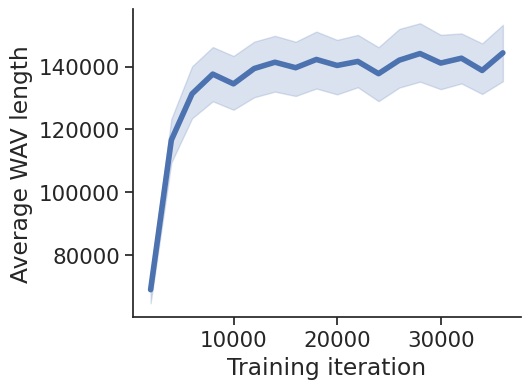

In [4]:
### Figure 14
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=results_df, x='epoch', y='avg_wav_len', linewidth=line_size)
plot.set(ylabel='Average WAV length', xlabel='Training iteration')
sns.despine()
plot.figure.savefig('plots/tts_avg_wavlen_epoch.pdf', bbox_inches='tight')
plot.figure.show();

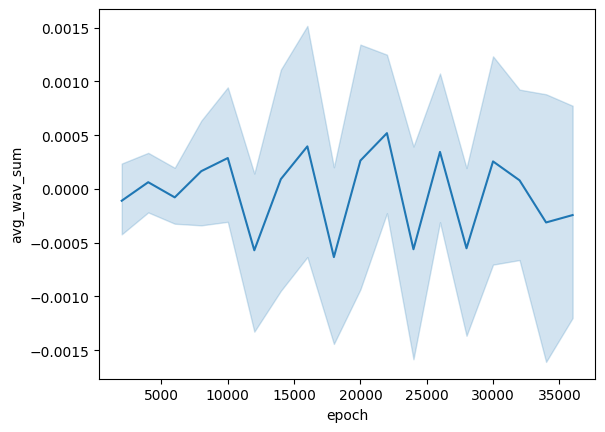

In [6]:
sns.lineplot(data=results_df, x='epoch', y='avg_wav_sum');

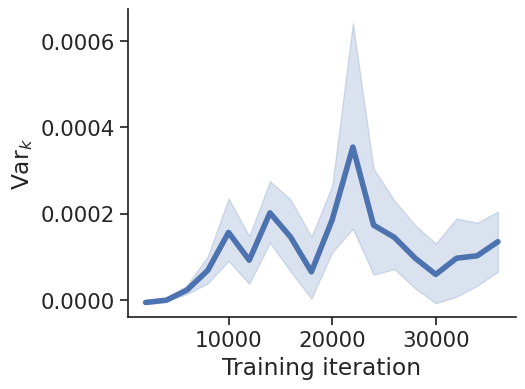

In [5]:
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=results_df, x='epoch', y='var_rbf', linewidth=line_size)
plot.set(ylabel='Var$_k$', xlabel='Training iteration')
sns.despine()
plot.figure.savefig('plots/tts_var_rbf_epoch.pdf', bbox_inches='tight')
plot.figure.show();

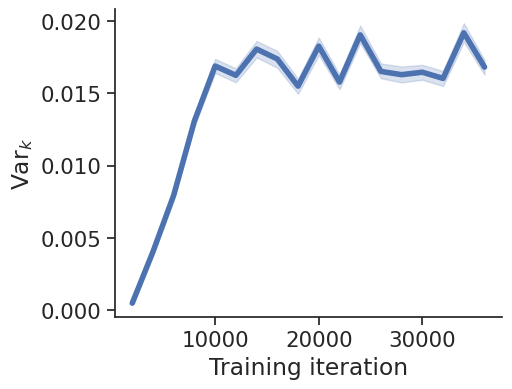

In [3]:
### Figure 6 Mid
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 4
plot = sns.lineplot(data=results_df, x='epoch', y='var_lap', linewidth=line_size)
plot.set(ylabel='Var$_k$', xlabel='Training iteration')
sns.despine()
plot.axes.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
plot.figure.savefig('plots/tts_var_epoch.pdf', bbox_inches='tight')
plot.figure.show();

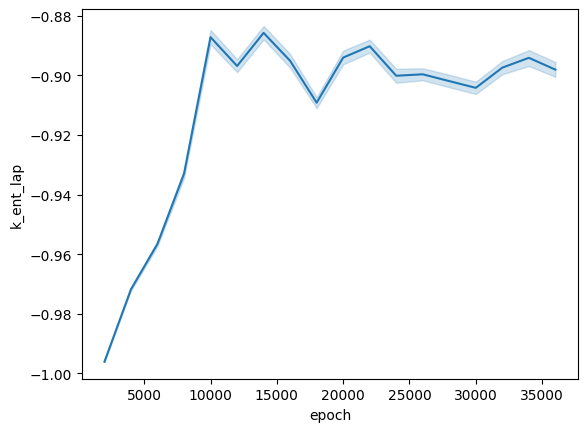

In [8]:
sns.lineplot(data=results_df, x='epoch', y='k_ent_lap');

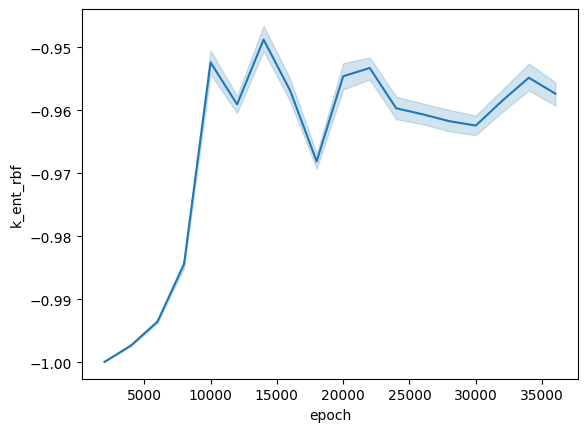

In [9]:
sns.lineplot(data=results_df, x='epoch', y='k_ent_rbf');

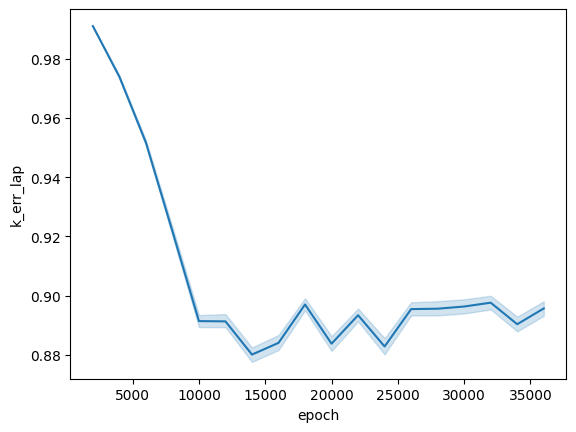

In [10]:
sns.lineplot(data=results_df, x='epoch', y='k_err_lap');

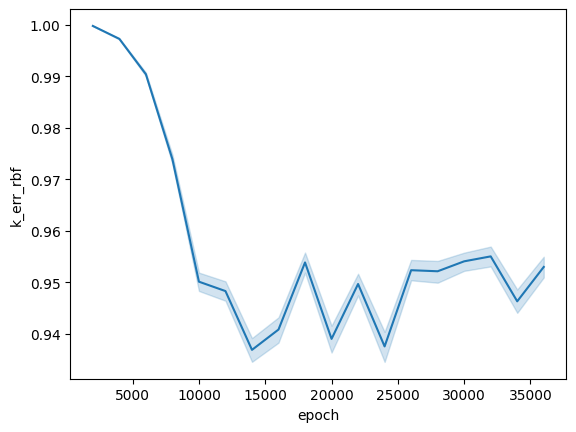

In [11]:
sns.lineplot(data=results_df, x='epoch', y='k_err_rbf');

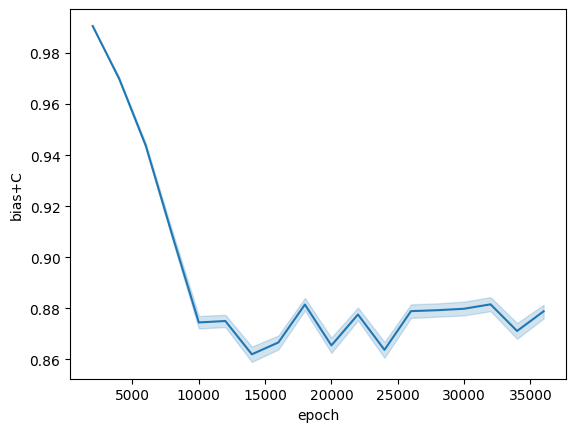

In [12]:
sns.lineplot(data=results_df, x='epoch', y='bias+C');

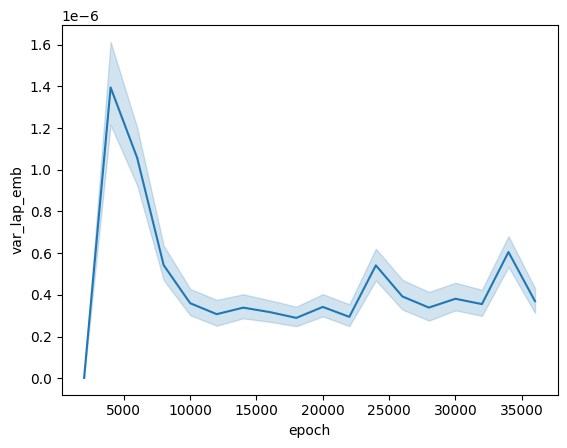

In [3]:
sns.lineplot(data=results_df, x='epoch', y='var_lap_emb');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


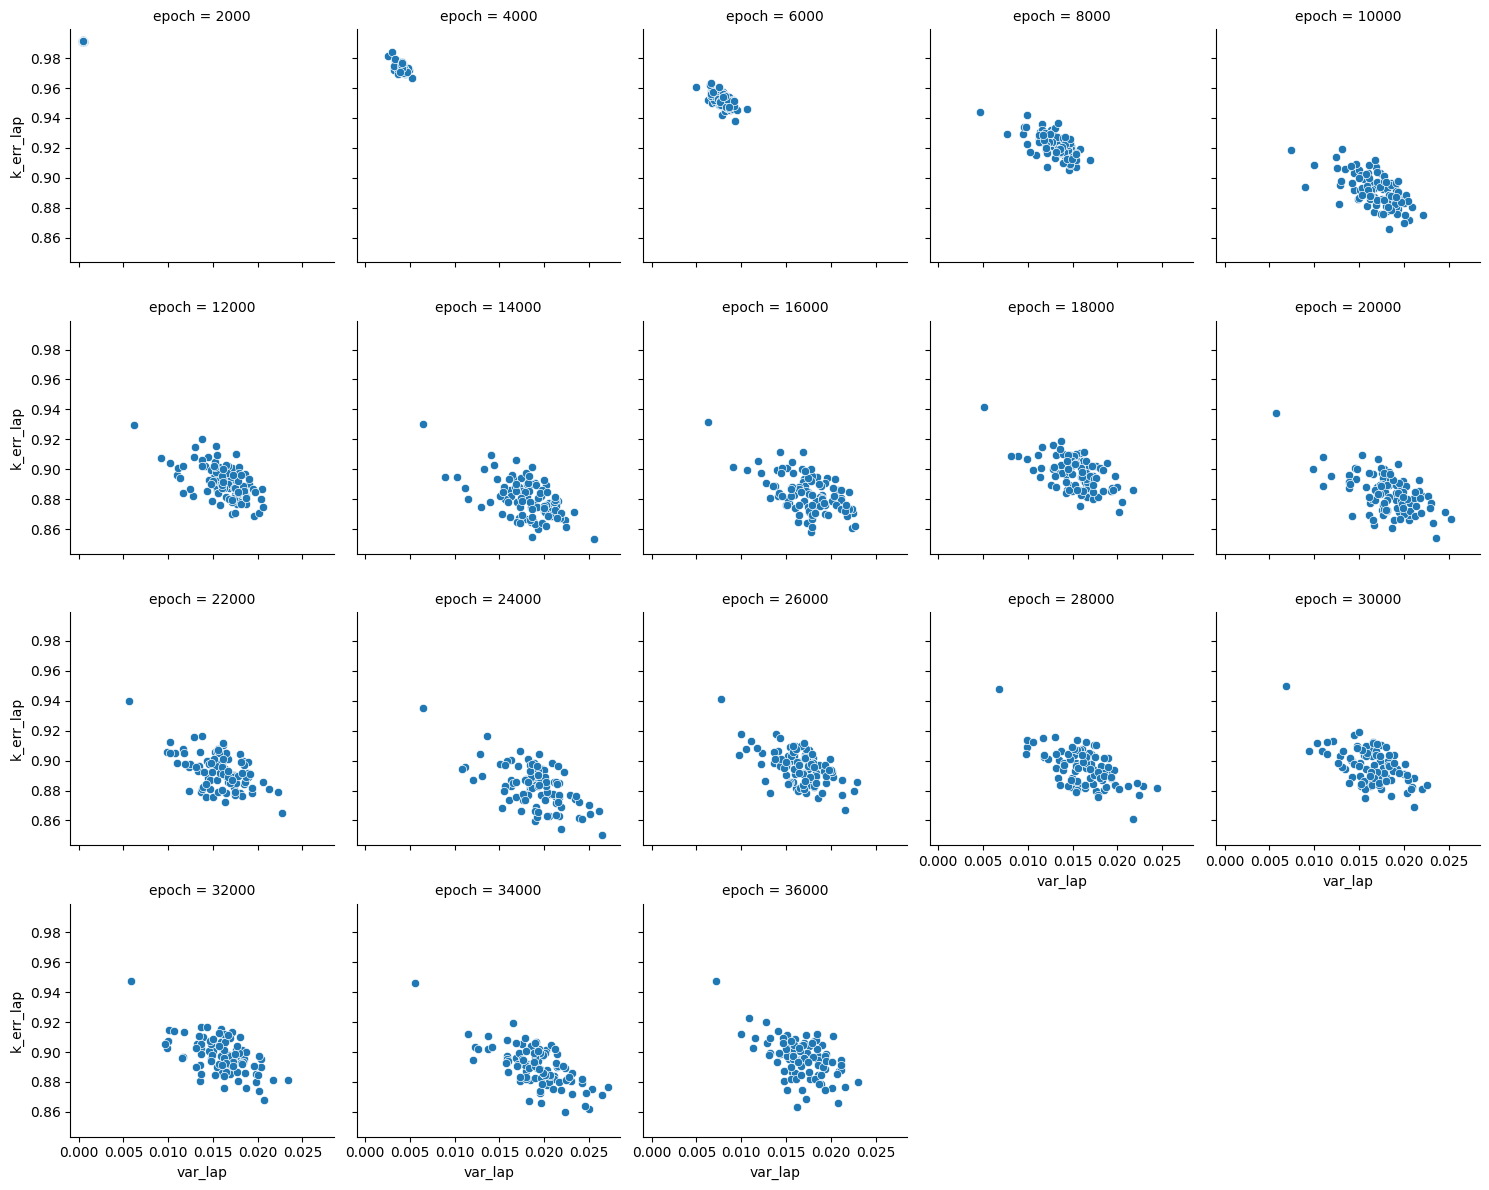

In [13]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'var_lap', 'k_err_lap');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


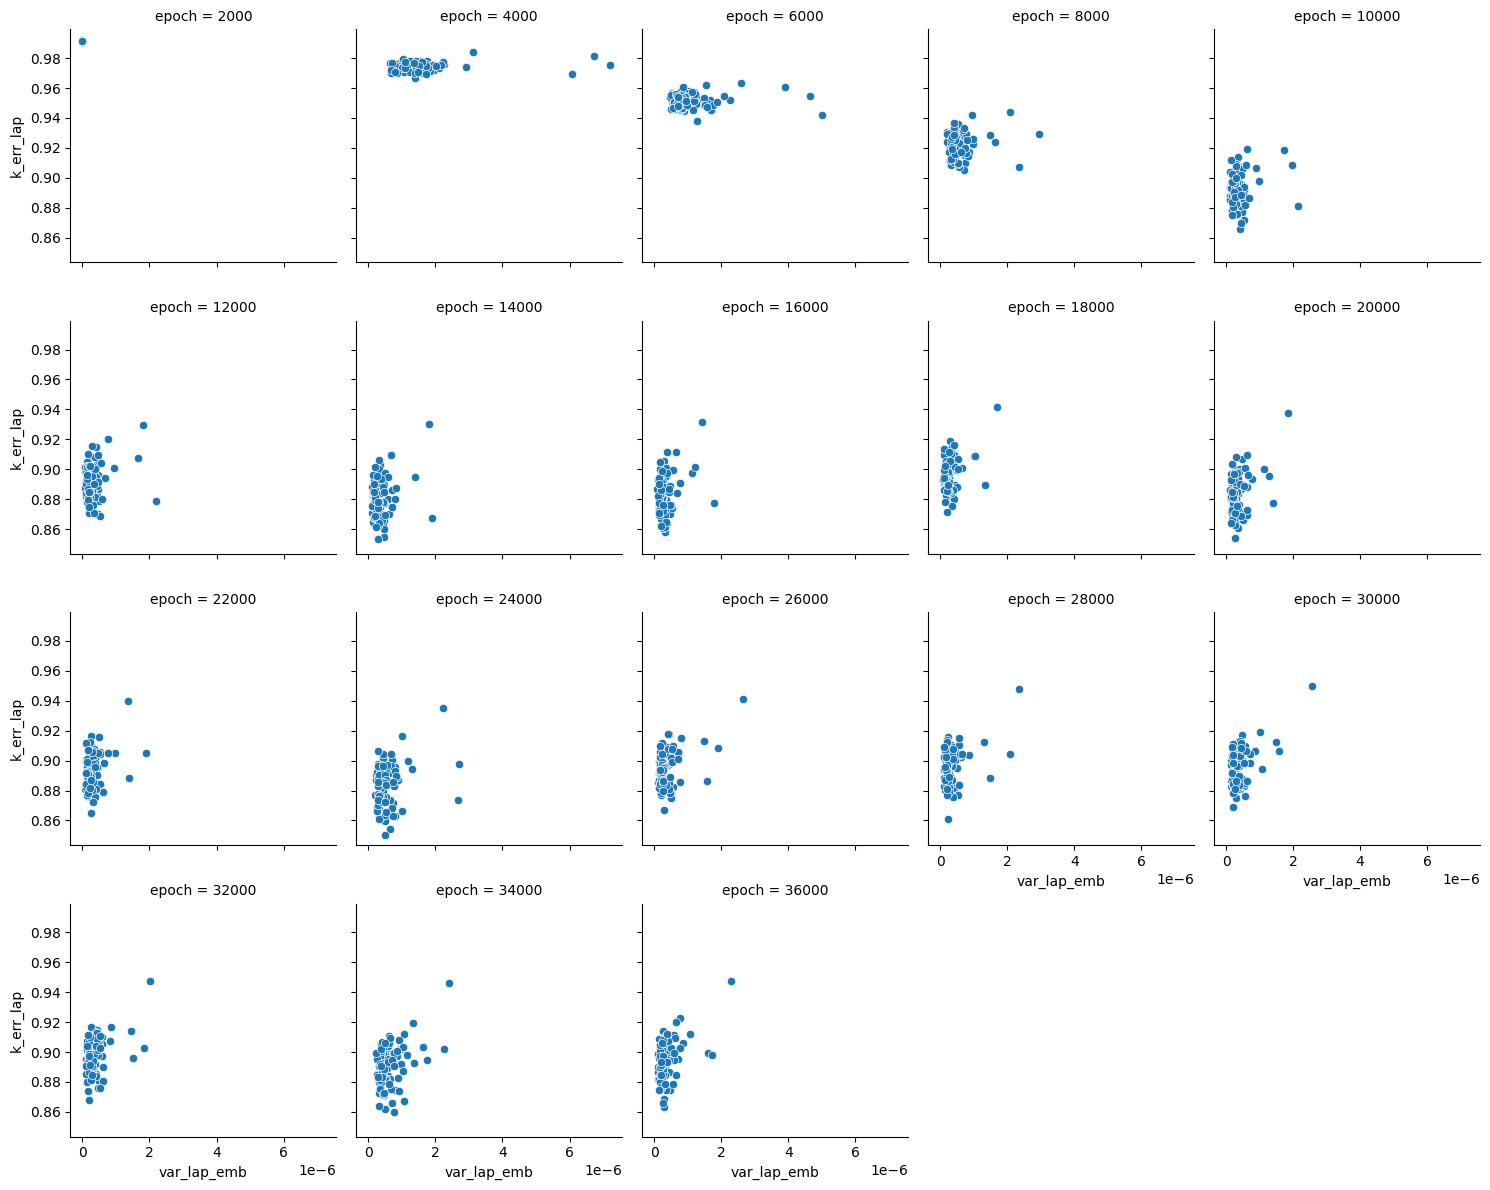

In [14]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'var_lap_emb', 'k_err_lap');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


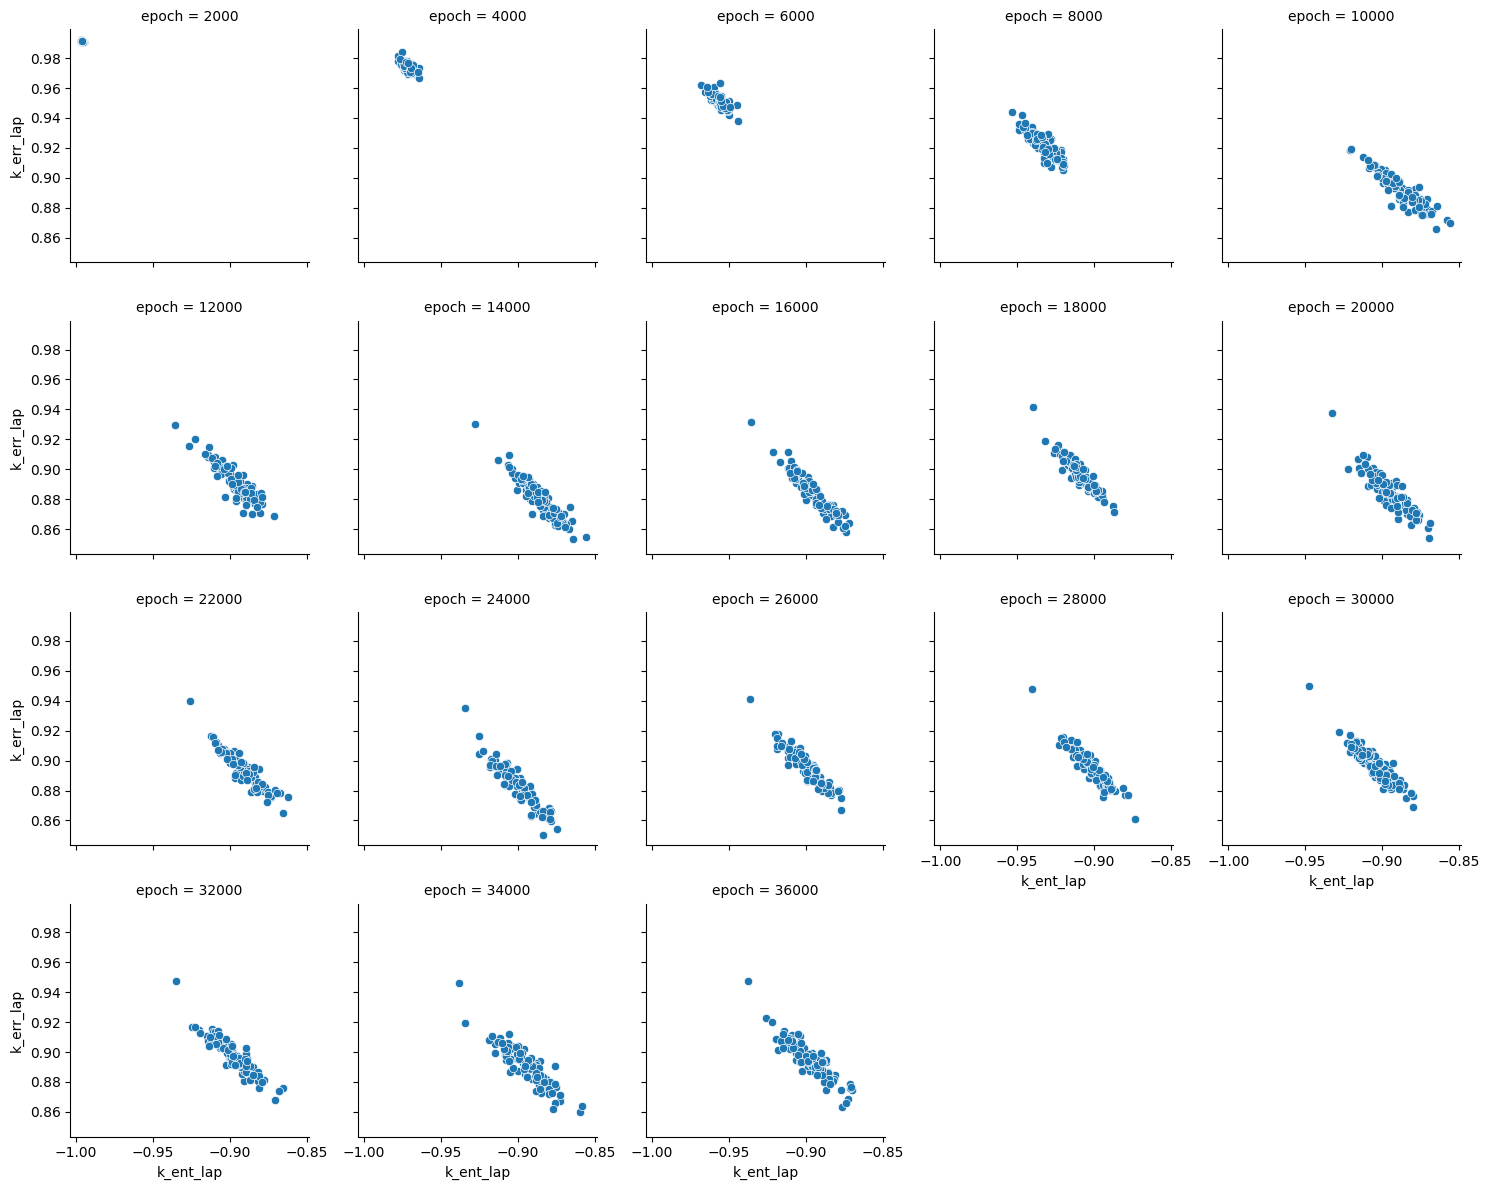

In [15]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'k_ent_lap', 'k_err_lap');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


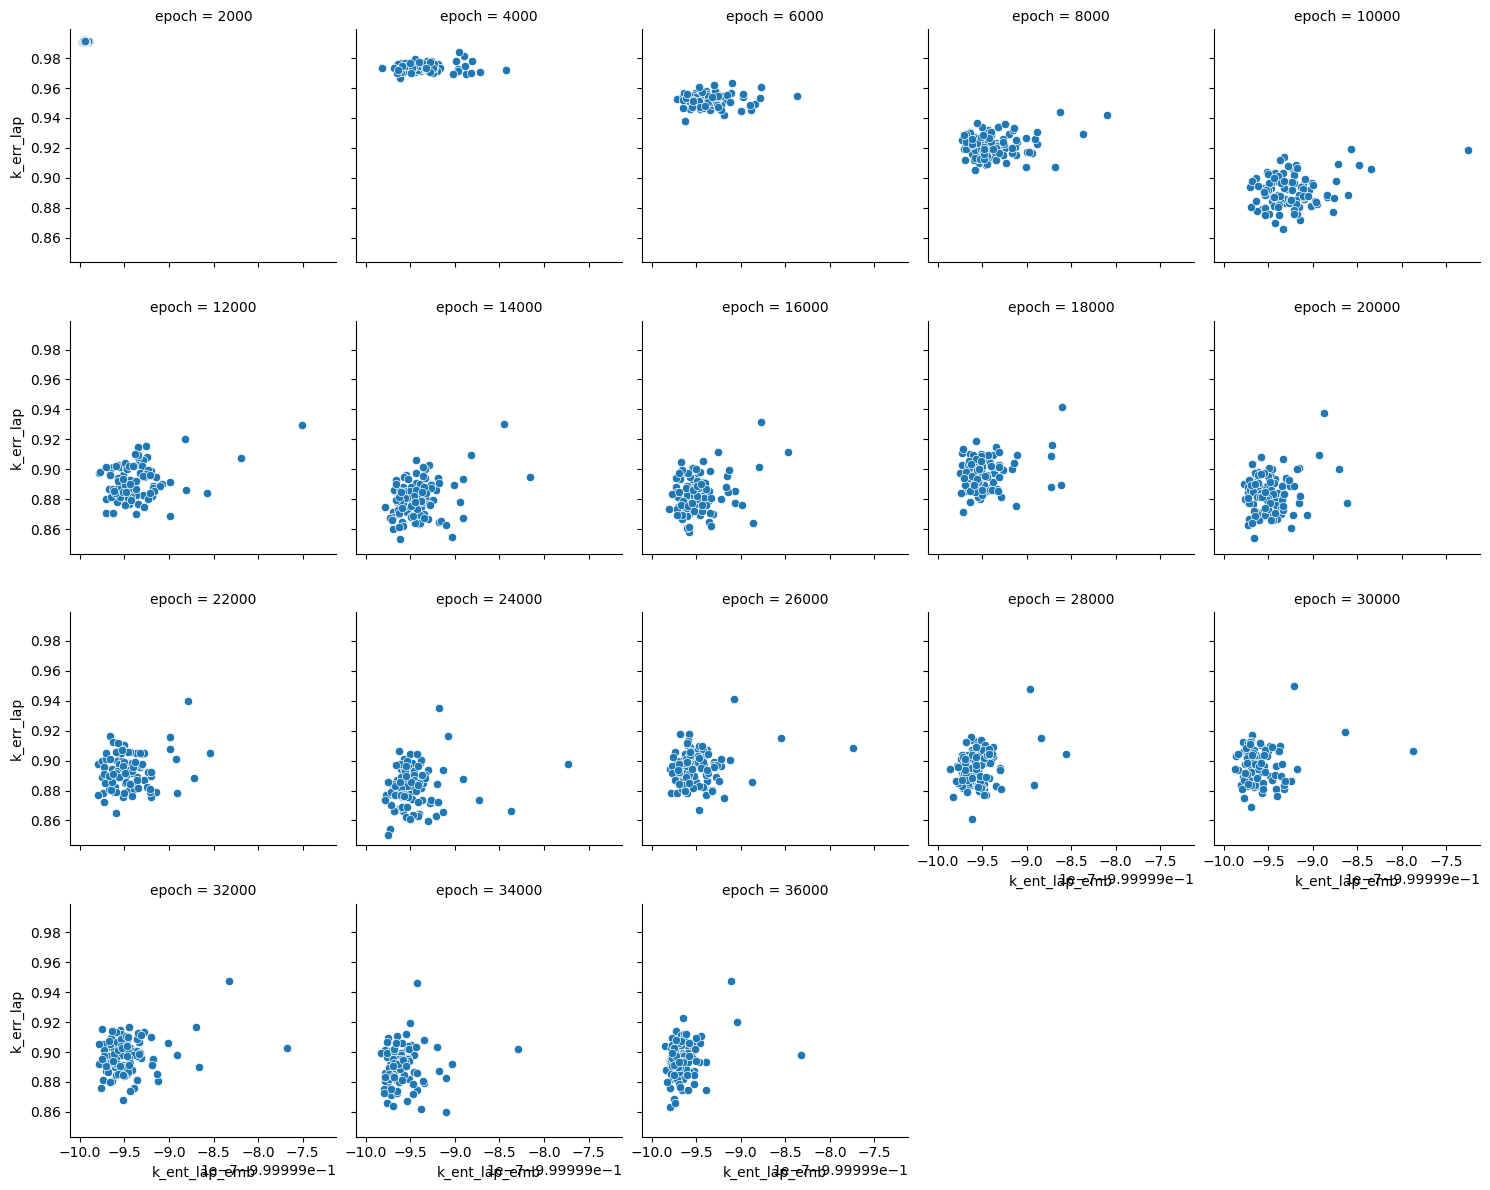

In [16]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'k_ent_lap_emb', 'k_err_lap');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


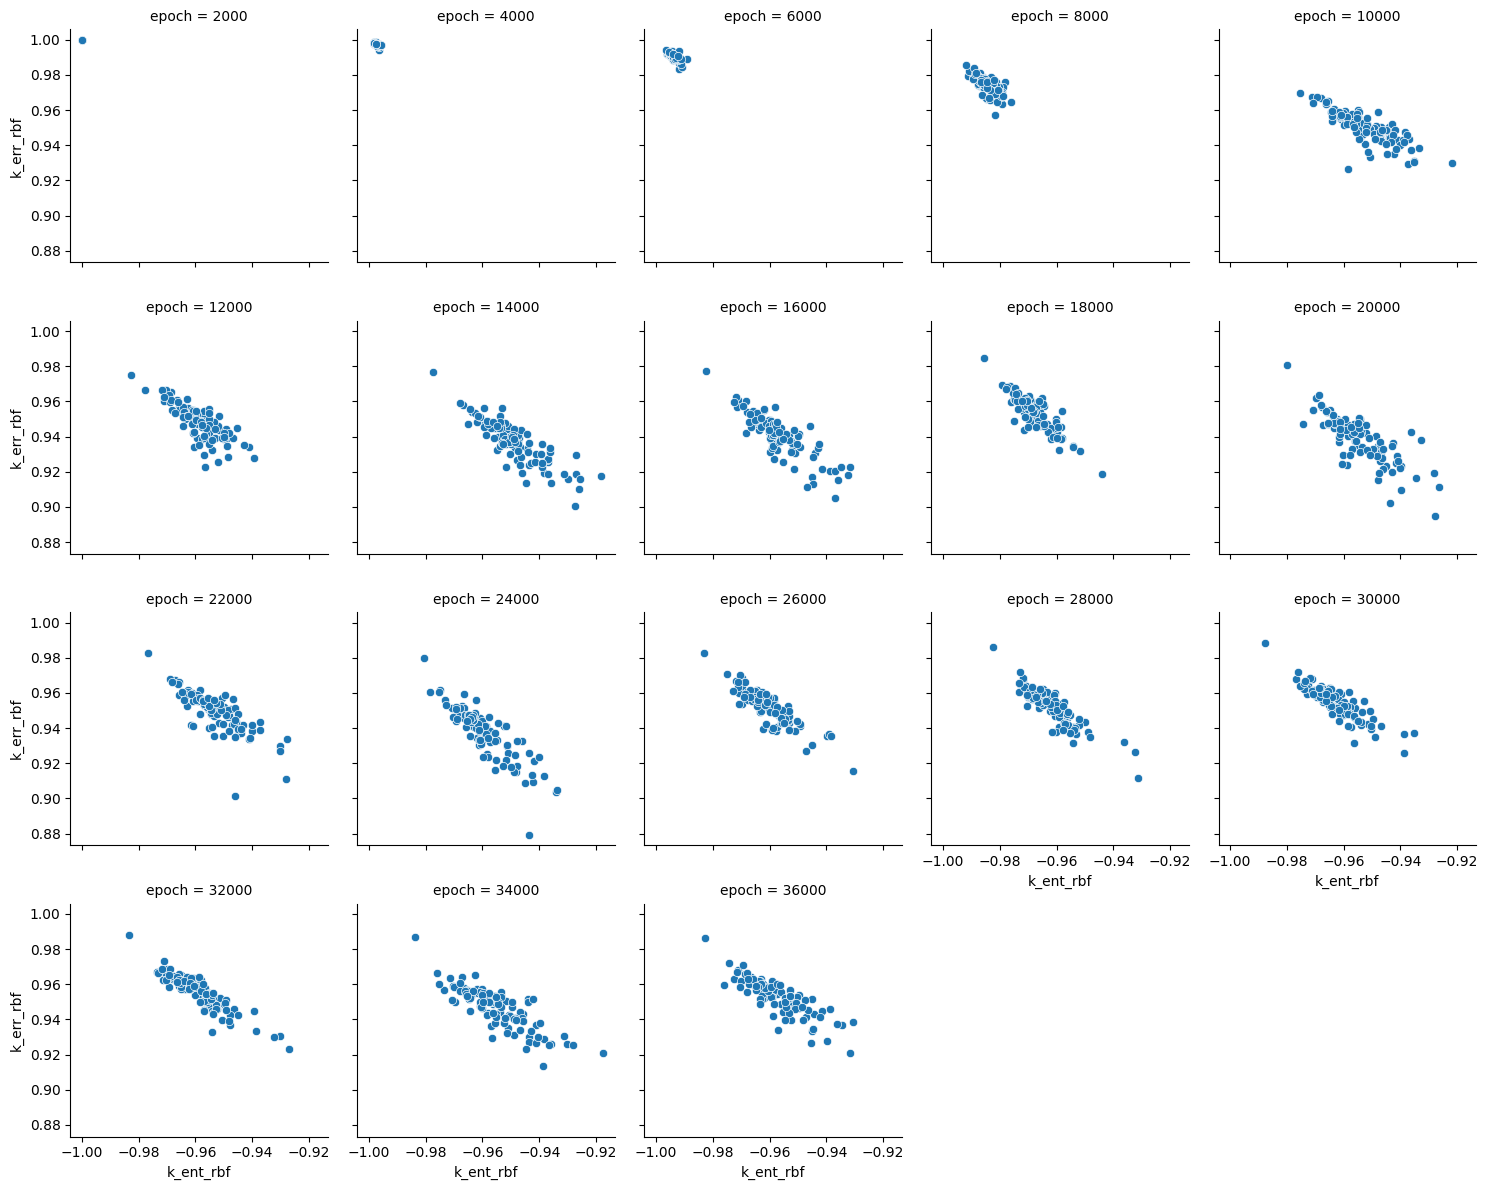

In [17]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'k_ent_rbf', 'k_err_rbf');

/home/sgruber/miniconda3/envs/TTS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


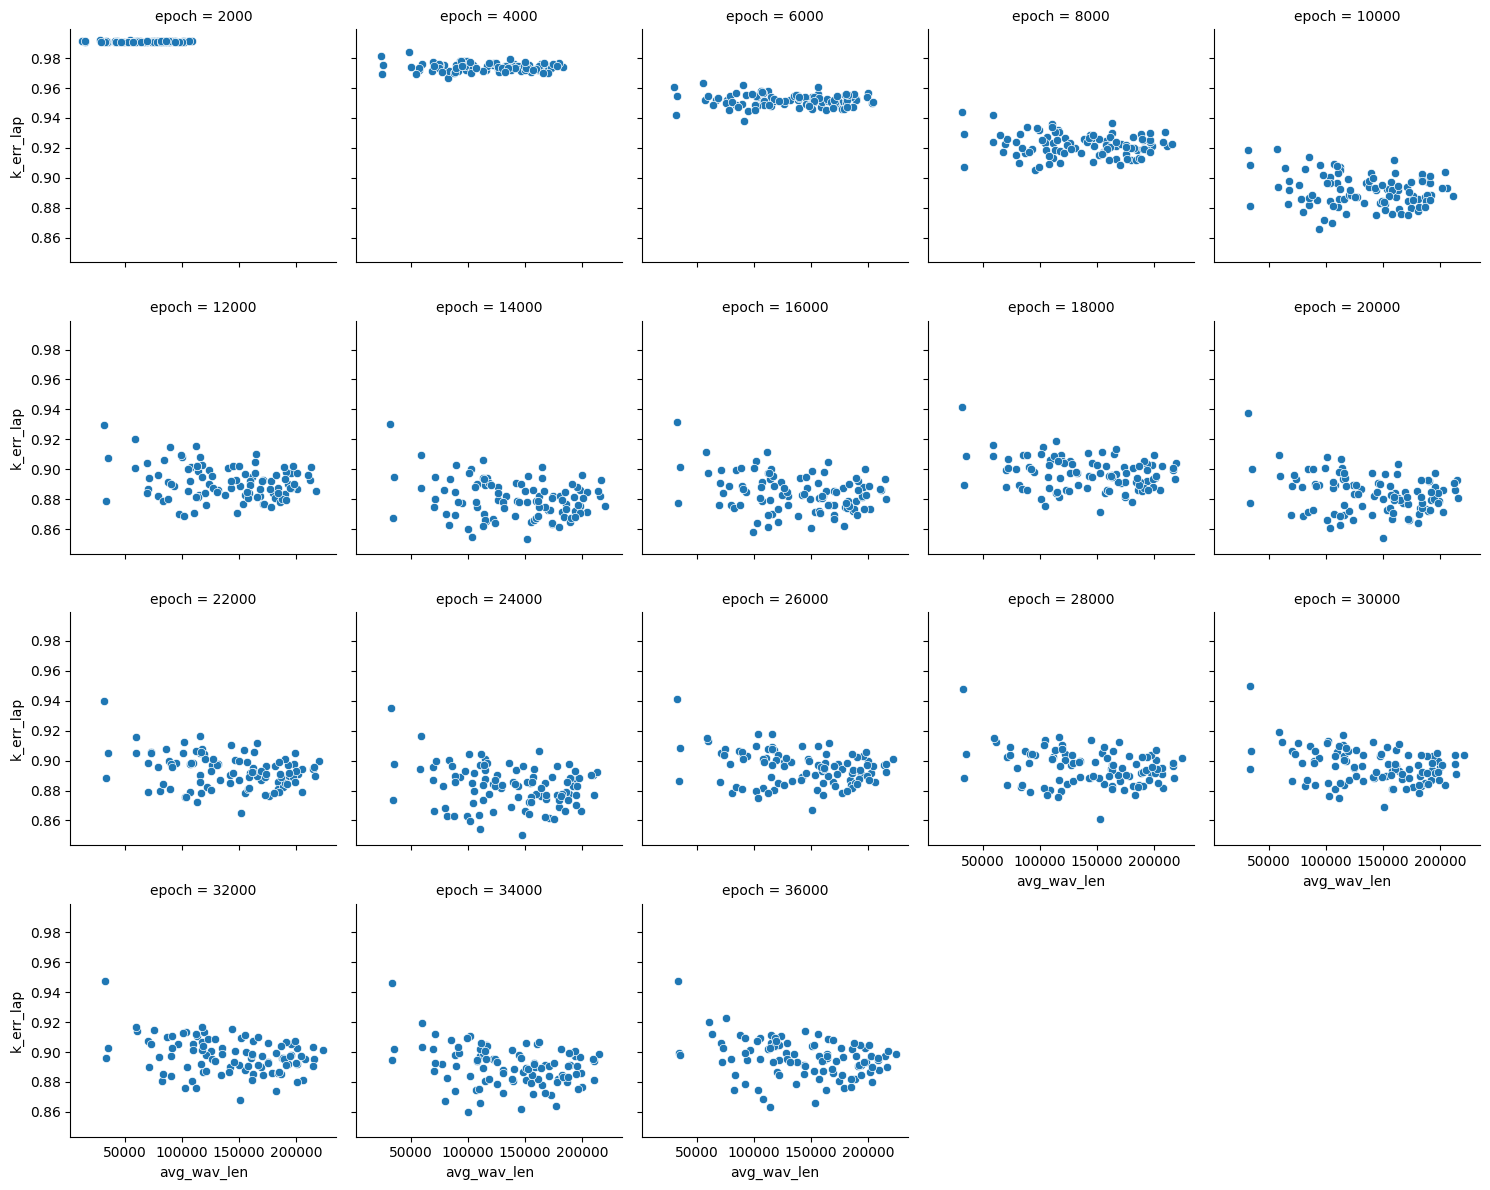

In [18]:
g = sns.FacetGrid(data=results_df, col='epoch', col_wrap=5)
g.map(sns.scatterplot, 'avg_wav_len', 'k_err_lap');

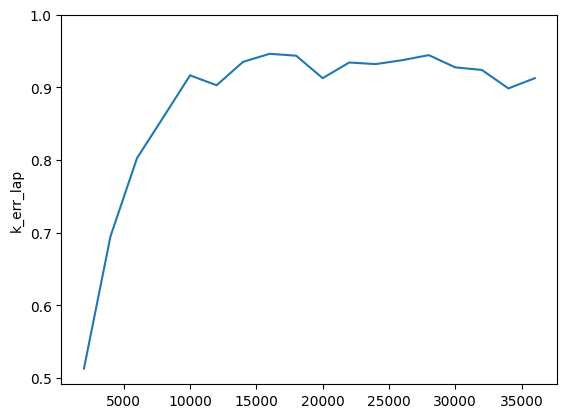

In [13]:
# pearson; k-ent-lap vs k-err-lap
ys = -1*results_df.groupby('epoch')[['k_ent_lap', 'k_err_lap']].corr(method='pearson').reset_index()['k_err_lap'][range(0,36,2)]
xs = list(range(2000, 36001, 2000))
sns.lineplot(y=ys, x=xs).set(ylim=(None,1));

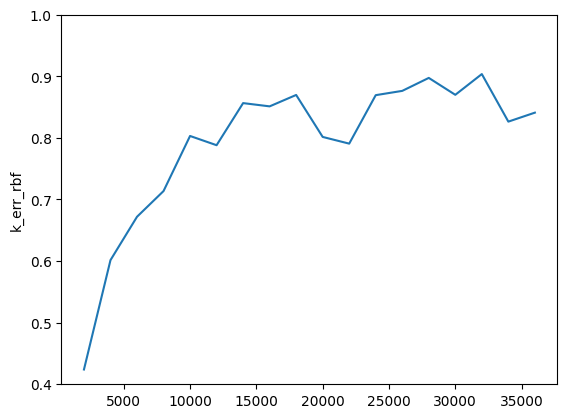

In [29]:
ys = -1*results_df.groupby('epoch')[['k_ent_rbf', 'k_err_rbf']].corr(method='pearson').reset_index()['k_err_rbf'][range(0,36,2)]
xs = list(range(2000, 36001, 2000))
sns.lineplot(y=ys, x=xs).set(ylim=(None,1));

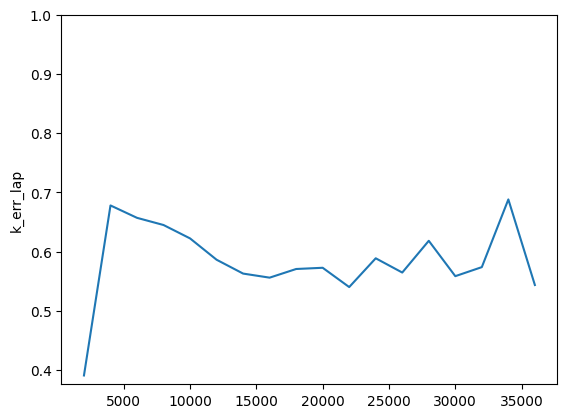

In [30]:
ys = -1*results_df.groupby('epoch')[['var_lap', 'k_err_lap']].corr(method='pearson').reset_index()['k_err_lap'][range(0,36,2)]
xs = list(range(2000, 36001, 2000))
sns.lineplot(y=ys, x=xs).set(ylim=(None,1));

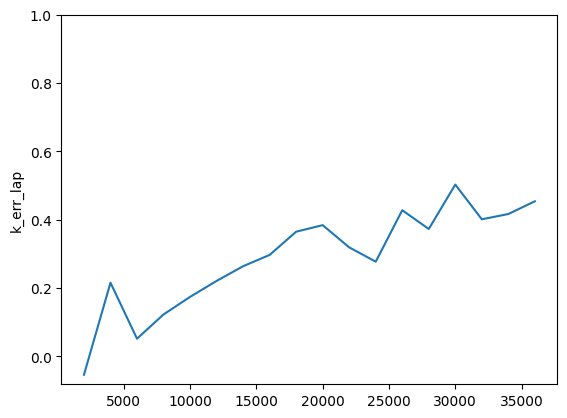

In [31]:
ys = results_df.groupby('epoch')[['var_lap_emb', 'k_err_lap']].corr(method='pearson').reset_index()['k_err_lap'][range(0,36,2)]
xs = list(range(2000, 36001, 2000))
sns.lineplot(y=ys, x=xs).set(ylim=(None,1));

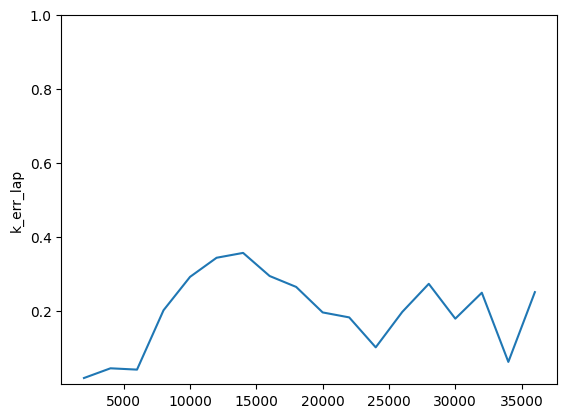

In [32]:
ys = results_df.groupby('epoch')[['k_ent_lap_emb', 'k_err_lap']].corr(method='pearson').reset_index()['k_err_lap'][range(0,36,2)]
xs = list(range(2000, 36001, 2000))
sns.lineplot(y=ys, x=xs).set(ylim=(None,1));

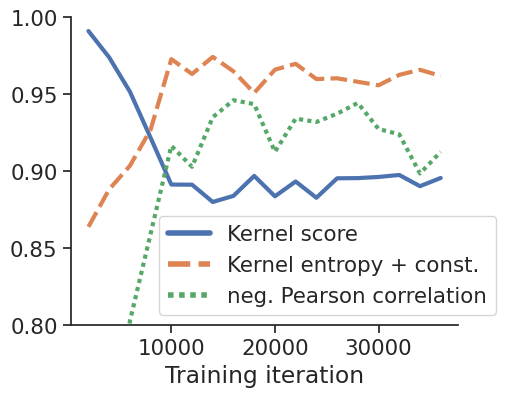

In [6]:
### Figure 6 Left
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 3
results_df['k_ent_lap + c'] = results_df['k_ent_lap'] + 1.86
sub_df = results_df.groupby('epoch')[['k_err_lap', 'k_ent_lap + c']].mean()
sub_df['-Corr'] = -1*results_df.groupby('epoch')[['k_ent_lap', 'k_err_lap']].corr(method='pearson').reset_index()['k_err_lap'][range(0,36,2)].values
sub_df[['Kernel score', 'Kernel entropy + const.', 'neg. Pearson correlation']] = sub_df[['k_err_lap', 'k_ent_lap + c', '-Corr']]
plot = sns.lineplot(sub_df[['Kernel score', 'Kernel entropy + const.', 'neg. Pearson correlation']], linewidth=line_size)
plot.set(ylim=(0.8, 1.0), xlabel='Training iteration')
sns.despine()
plot.axes.set_yticks([0.8, 0.85, 0.9, 0.95, 1])
leg = plt.legend(loc='lower left', bbox_to_anchor=(0.2, 0))
for line in leg.get_lines():
    line.set_linewidth(4)
plot.figure.savefig('plots/tts_ent_err_corr.pdf', bbox_inches='tight')
plot.figure.show();

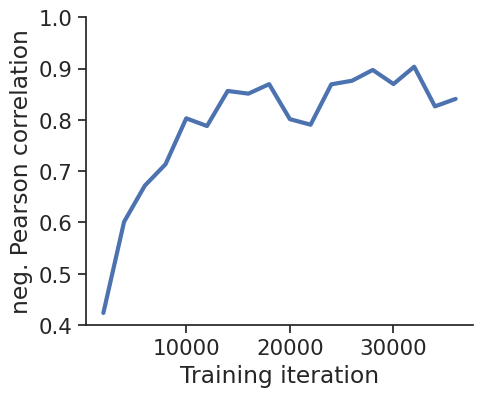

In [8]:
### Figure 15
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 3
results_df['k_ent_rbf + c'] = results_df['k_ent_rbf'] + 1.86
sub_df = results_df.groupby('epoch')[['k_err_rbf', 'k_ent_rbf + c']].mean()
sub_df['-Corr'] = -1*results_df.groupby('epoch')[['k_ent_rbf', 'k_err_rbf']].corr(method='pearson').reset_index()['k_err_rbf'][range(0,36,2)].values
sub_df[['Kernel score', 'Kernel entropy + const.', 'neg. Pearson correlation']] = sub_df[['k_err_rbf', 'k_ent_rbf + c', '-Corr']]
plot = sns.lineplot(sub_df[['neg. Pearson correlation']], linewidth=line_size, legend=False)
plot.set(ylim=(None, 1.0), xlabel='Training iteration', ylabel='neg. Pearson correlation')
sns.despine()
plot.figure.savefig('plots/tts_rbf_corr.pdf', bbox_inches='tight')
plot.figure.show();

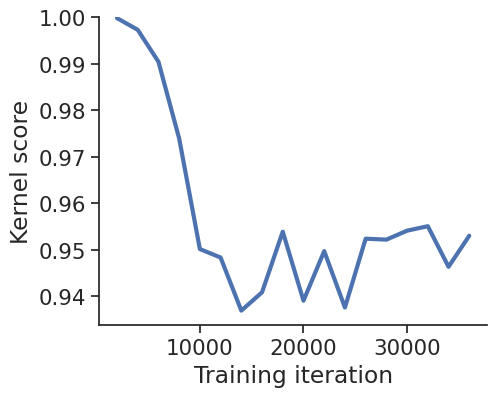

In [22]:
### Figure 15
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 3
results_df['k_ent_rbf + c'] = results_df['k_ent_rbf'] + 1.86
sub_df = results_df.groupby('epoch')[['k_err_rbf', 'k_ent_rbf + c']].mean()
sub_df['-Corr'] = -1*results_df.groupby('epoch')[['k_ent_rbf', 'k_err_rbf']].corr(method='pearson').reset_index()['k_err_rbf'][range(0,36,2)].values
sub_df[['Kernel score', 'Kernel entropy + const.', 'neg. Pearson correlation']] = sub_df[['k_err_rbf', 'k_ent_rbf + c', '-Corr']]
plot = sns.lineplot(sub_df[['Kernel score']], linewidth=line_size, legend=False)
plot.set(ylim=(None, 1.0), xlabel='Training iteration', ylabel='Kernel score')
sns.despine()
plot.figure.savefig('plots/tts_rbf_err.pdf', bbox_inches='tight')
plot.figure.show();

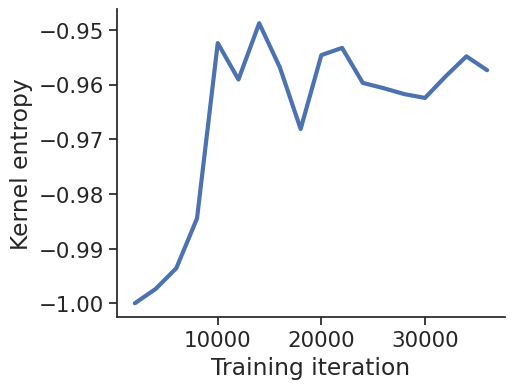

In [23]:
### Figure 15
plt.figure(figsize=(5, 4))
sns.set(font_scale=1.4)
sns.set_style('ticks')
line_size = 3
sub_df = results_df.groupby('epoch')[['k_err_rbf', 'k_ent_rbf']].mean()
sub_df[['Kernel entropy']] = sub_df[['k_ent_rbf']]
plot = sns.lineplot(sub_df[['Kernel entropy']], linewidth=line_size, legend=False)
plot.set(xlabel='Training iteration', ylabel='Kernel entropy')
sns.despine()
plot.figure.savefig('plots/tts_rbf_ent.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_16237/2031844768.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


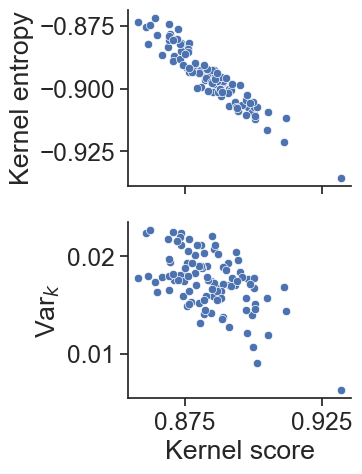

In [6]:
### Figure 6 Right
#plt.figure(figsize=(5, 5))
sns.set(font_scale=1.6)
sns.set_style('ticks')
sub_results = results_df[results_df['epoch'].isin([16000])]
y_vars = ['k_ent_lap', 'var_lap']
x_vars = ['k_err_lap']
#g = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, hue='Epoch')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, aspect=1.4)
plot.map(sns.scatterplot)
plot.set(xlabel='Kernel score')
plot.axes[0,0].yaxis.set_label_text('Kernel entropy', visible=True)
plot.axes[0,0].set_xticks([0.875, 0.925])
plot.axes[1,0].yaxis.set_label_text('Var$_k$', visible=True)
plot.axes[1,0].set_xticks([0.875, 0.925])
plot.figure.savefig('plots/tts_scatter_pke_var_vs_kerr.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_16237/1524369862.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


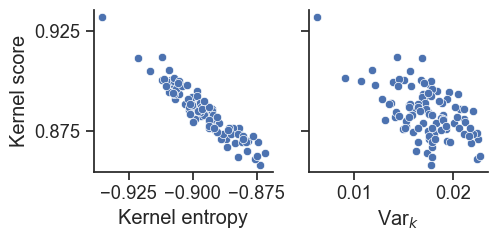

In [14]:
#plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)
sns.set_style('ticks')
sub_results = results_df[results_df['epoch'].isin([16000])]
x_vars = ['k_ent_lap', 'var_lap']
y_vars = ['k_err_lap']
#g = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, hue='Epoch')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, aspect=1)
plot.map(sns.scatterplot)
plot.set(ylabel='Kernel score')
plot.axes[0,0].xaxis.set_label_text('Kernel entropy', visible=True)
plot.axes[0,0].set_yticks([0.875, 0.925])
plot.axes[0,1].xaxis.set_label_text('Var$_k$', visible=True)
plot.axes[0,1].set_yticks([0.875, 0.925])
plot.figure.savefig('plots/tts_scatter_pke_var_vs_kerr_horizontal.pdf', bbox_inches='tight')
plot.figure.show();

/var/folders/ft/r9cj4sz92lbfcwssbtg9tp680000gp/T/ipykernel_16237/357394831.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.figure.show();


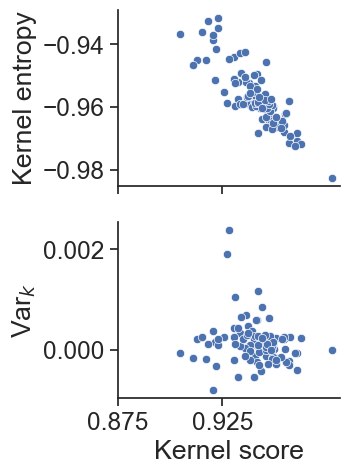

In [5]:
#plt.figure(figsize=(5, 5))
sns.set(font_scale=1.6)
sns.set_style('ticks')
sub_results = results_df[results_df['epoch'].isin([16000])]
y_vars = ['k_ent_rbf', 'var_rbf']
x_vars = ['k_err_rbf']
#g = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, hue='Epoch')
plot = sns.PairGrid(sub_results, x_vars=x_vars, y_vars=y_vars, aspect=1.4)
plot.map(sns.scatterplot)
plot.set(xlabel='Kernel score')
plot.axes[0,0].yaxis.set_label_text('Kernel entropy', visible=True)
plot.axes[0,0].set_xticks([0.875, 0.925])
plot.axes[1,0].yaxis.set_label_text('Var$_k$', visible=True)
plot.axes[1,0].set_xticks([0.875, 0.925])
plot.figure.savefig('plots/tts_scatter_pke_var_vs_kerr_rbf.pdf', bbox_inches='tight')
plot.figure.show();